In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd
import torch

/tmp/ipykernel_78762/3694697533.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def get_available_device() -> str:
    """Returns the device based on the system configuration."""
    if torch.cuda.is_available():
        return torch.device('cuda').type
    if torch.backends.mps.is_available():
        return torch.device('mps').type  # https://pytorch.org/docs/stable/notes/mps.html
    return torch.device('cpu').type

device = get_available_device()
print(f"Using device: {device}")

Using device: cpu


In [3]:
DIMENSIONS = (28, 28)
CHANNELS = 1  # grayscale
INPUT_SIZE = DIMENSIONS[0] * DIMENSIONS[1]
OUTPUT_SIZE = 10

def transform_data(
        is_convolutional: bool,
        x: pd.DataFrame,
        y: pd.Series | None = None) -> tuple[torch.tensor, torch.tensor]:
    """
    Transforms the data. Returns a tuple of (x, y) where x is a tensor of the features and y is a
    tensor of the labels.

    Args:
        is_convolutional: A boolean indicating whether the model is convolutional.
        x: A dataframe of the features.
        y: A series of the labels.
    """
    x = torch.tensor(x.values, dtype=torch.float32)
    # Normalize the tensor
    x_min = x.min()
    x_max = x.max()
    x = (x - x_min) / (x_max - x_min)
    assert x.min() == 0
    assert x.max() == 1
    if is_convolutional:
        # Reshape data to have channel dimension
        # MNIST images are 28x28, so we reshape them to [batch_size, 1, 28, 28]
        x = x.reshape(-1, CHANNELS, DIMENSIONS[0], DIMENSIONS[1])
    if y is not None:
        y = torch.tensor(y.astype(int).values, dtype=torch.long)
    return x, y


def get_data():  # noqa
    """Function is required by and called from `model_pipeline()`."""
    x, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
    x, y = transform_data(is_convolutional=True, x=x, y=y)
    # 80% train; 10% validation; 10% test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
    print(f"Training set  : X-{x_train.shape}, y-{y_train.shape}")
    print(f"Validation set: X-{x_val.shape}, y-{y_val.shape}")
    print(f"Test set      : X-{x_test.shape}, y-{y_test.shape}")
    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = get_data()

Training set  : X-torch.Size([56000, 1, 28, 28]), y-torch.Size([56000])
Validation set: X-torch.Size([7000, 1, 28, 28]), y-torch.Size([7000])
Test set      : X-torch.Size([7000, 1, 28, 28]), y-torch.Size([7000])


In [5]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

class Convolutional(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1) # input channel, output channel, kernel size
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128) # 32 channels, image size: 7x7
        self.fc2 = nn.Linear(128, 10) # output 10 classes

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2) # 28x28 -> 14x14
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) # 14x14 -> 7x7
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

learning_rate = 0.01
epochs = 15
batch_size = 32

x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = Convolutional()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
losses = []
val_losses = []

start = time.time()
for epoch in range(epochs):
    for batch, (inputs, targets) in enumerate(dataloader):
        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        if batch % 400 == 0:
            losses.append(loss.item())
            # calculate validation loss
            with torch.no_grad():
                val_outputs = model(x_val)
                val_loss = criterion(val_outputs, y_val)
                val_losses.append(val_loss.item())
            print(f"Epoch {epoch}, Batch {batch:04}, training loss {round(loss.item(), 3)}, validation loss {round(val_loss.item(), 3)}")  # noqa
end = time.time()

Epoch 0, Batch 0000, training loss 2.312, validation loss 2.305
Epoch 0, Batch 0400, training loss 1.483, validation loss 1.384
Epoch 0, Batch 0800, training loss 0.466, validation loss 0.47
Epoch 0, Batch 1200, training loss 0.165, validation loss 0.32
Epoch 0, Batch 1600, training loss 0.076, validation loss 0.294
Epoch 1, Batch 0000, training loss 0.548, validation loss 0.268
Epoch 1, Batch 0400, training loss 0.379, validation loss 0.26
Epoch 1, Batch 0800, training loss 0.194, validation loss 0.211
Epoch 1, Batch 1200, training loss 0.273, validation loss 0.186
Epoch 1, Batch 1600, training loss 0.184, validation loss 0.175
Epoch 2, Batch 0000, training loss 0.133, validation loss 0.16
Epoch 2, Batch 0400, training loss 0.028, validation loss 0.158
Epoch 2, Batch 0800, training loss 0.06, validation loss 0.146
Epoch 2, Batch 1200, training loss 0.247, validation loss 0.131
Epoch 2, Batch 1600, training loss 0.098, validation loss 0.125
Epoch 3, Batch 0000, training loss 0.221, val

In [6]:
print(f"Training took {round(end - start, 2)} seconds on {device}")

Training took 2867.29 seconds on cpu


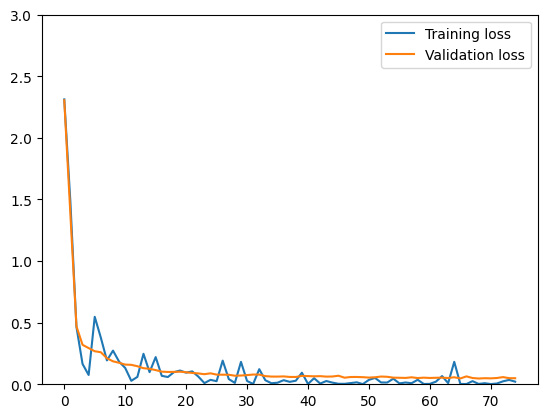

In [7]:
# plot losses over time
plt.plot(losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.ylim(0, 3)
plt.legend()

In [8]:
x_test = x_test.to(device)
y_test = y_test.to(device)

# test the model
with torch.no_grad():
    outputs = model(x_test)
    loss = criterion(outputs, y_test)
    print(f"Test loss: {loss}")
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).sum().item() / y_test.size(0)
    print(f"Test accuracy: {accuracy:.3f}")

Test loss: 0.047276224941015244
Test accuracy: 0.985


Text(0.5, 1.0, 'Count of Misclassified Samples by Class')

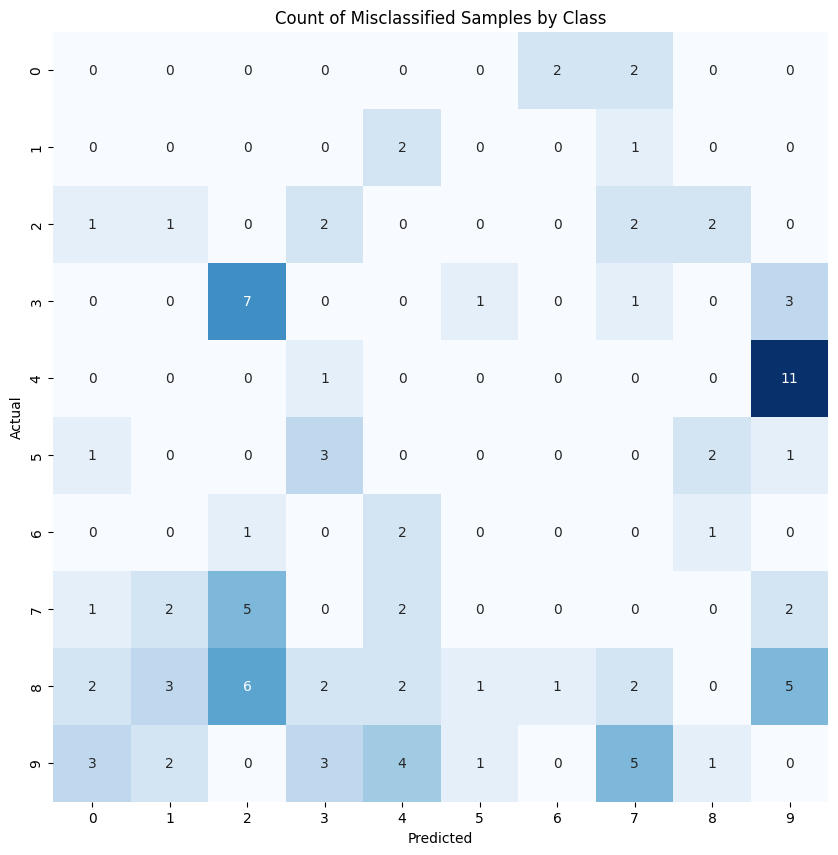

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test.cpu(), predicted.cpu())
# remove the diagonal values (correct predictions) for better visualization
np.fill_diagonal(cm, 0)
fig = plt.figure(figsize=(OUTPUT_SIZE, OUTPUT_SIZE))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Count of Misclassified Samples by Class')

---